# Data Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

all_interactions = pd.read_csv("/content/drive/MyDrive/summary_feedback.csv")
all_clicks = pd.read_csv("/content/drive/MyDrive/click_summary_dataset.csv")


# Distinguish interactions before and after click
# Only interactions before click are meaningful

movie_clicks = all_interactions[all_interactions["Click_AOI_type"] == "Movie"]

first_click = (
    movie_clicks
    .reset_index()                                # turn the index into a column
    .groupby(["UserID", "TaskID"])["index"]      # group by user+task
    .min()                                        # pick the earliest index
    .rename("first_click_index")
    .reset_index()
)

df = (
    all_interactions                              # bring original index into a column
    .merge(first_click, on=["UserID", "TaskID"], how="left")
)

interactions_before_click = df[df.index <= df["first_click_index"]]


# for free browsing
interactions_before_click.loc[interactions_before_click["Fixation_AOI_type"] == "Genre", "Fixation_AOI_Movie_position_in_carousel"] = 0.0
interactions_before_click_free_browsing = interactions_before_click.query("TaskID <= 30").copy()
interactions_before_click_free_browsing = interactions_before_click_free_browsing[
    interactions_before_click_free_browsing["Fixation_AOI_Movie_position_in_carousel"].notna()
]

delete_pairs = []

for (user, task), subset in interactions_before_click_free_browsing.groupby(
    ["UserID", "TaskID"]
):
    click = movie_clicks[
        (movie_clicks["UserID"] == user) & (movie_clicks["TaskID"] == task)
    ]

    visit = (
        subset["Fixation_AOI_Carousel_position"]
        == click["Click_AOI_Carousel_position"].iloc[0]
    ) & (
        subset["Fixation_AOI_Movie_position_in_carousel"]
        == click["Click_AOI_Movie_position_in_carousel"].iloc[0]
    )

    matches = visit.astype(int)
    shifted = matches.shift(1, fill_value=0)
    visit_start = (matches == 1) & (shifted == 0)
    visit_end = (matches == 0) & (shifted == 1)
    num_visits = visit_start.sum()

    if num_visits == 0:
        delete_pairs.append((user, task))


interactions_before_click_free_browsing = interactions_before_click_free_browsing[
    ~interactions_before_click_free_browsing[["UserID", "TaskID"]].apply(
        tuple, axis=1
    ).isin(delete_pairs)
]

out = all_clicks['Movie_Familiarity'].unique()[-3:-1]
keep = all_clicks[~all_clicks["Movie_Familiarity"].isin(out)]
interactions_before_click_free_browsing = interactions_before_click_free_browsing.merge(
    keep[['TaskID', 'UserID']],
    on=['TaskID', 'UserID'],
    how='inner'
)

Mounted at /content/drive


# Figure 3 in the paper

In [2]:
aoi_col = "Fixation_AOI_type"
user_col = "UserID"
task_col = "TaskID"
order_col = "Timestamp"

x_col = "Fixation_AOI_Carousel_position"
y_col = "Fixation_AOI_Movie_position_in_carousel"

df = interactions_before_click_free_browsing.copy()

dup_col = "duplicate"
cond = (df[x_col] == df[x_col].shift(1)) & (df[y_col] == df[y_col].shift(1)) \
        & (df[user_col] == df[user_col].shift(1)) \
        & (df[task_col] == df[task_col].shift(1))
df[dup_col] = cond
df = df[~df[dup_col]].copy()

stats = df.groupby([user_col, task_col, x_col, y_col]).size().reset_index(name='n_visits')
each_carousel = stats.groupby([x_col, user_col, task_col]).size().reset_index().groupby([x_col])[[user_col, task_col]].size().reset_index(name="exam_row")
binary_exam_result = stats.groupby([x_col, y_col]).size().reset_index(name='n_users_tasks')
n_pairs = stats.groupby([user_col, task_col]).size().shape[0]
binary_exam_result['exam_freq'] = binary_exam_result['n_users_tasks'] / n_pairs * 100
binary_exam_result = binary_exam_result.merge(each_carousel, on = ['Fixation_AOI_Carousel_position'], how='left')
binary_exam_result["inner_freq"] = binary_exam_result["n_users_tasks"] / binary_exam_result["exam_row"] * 100

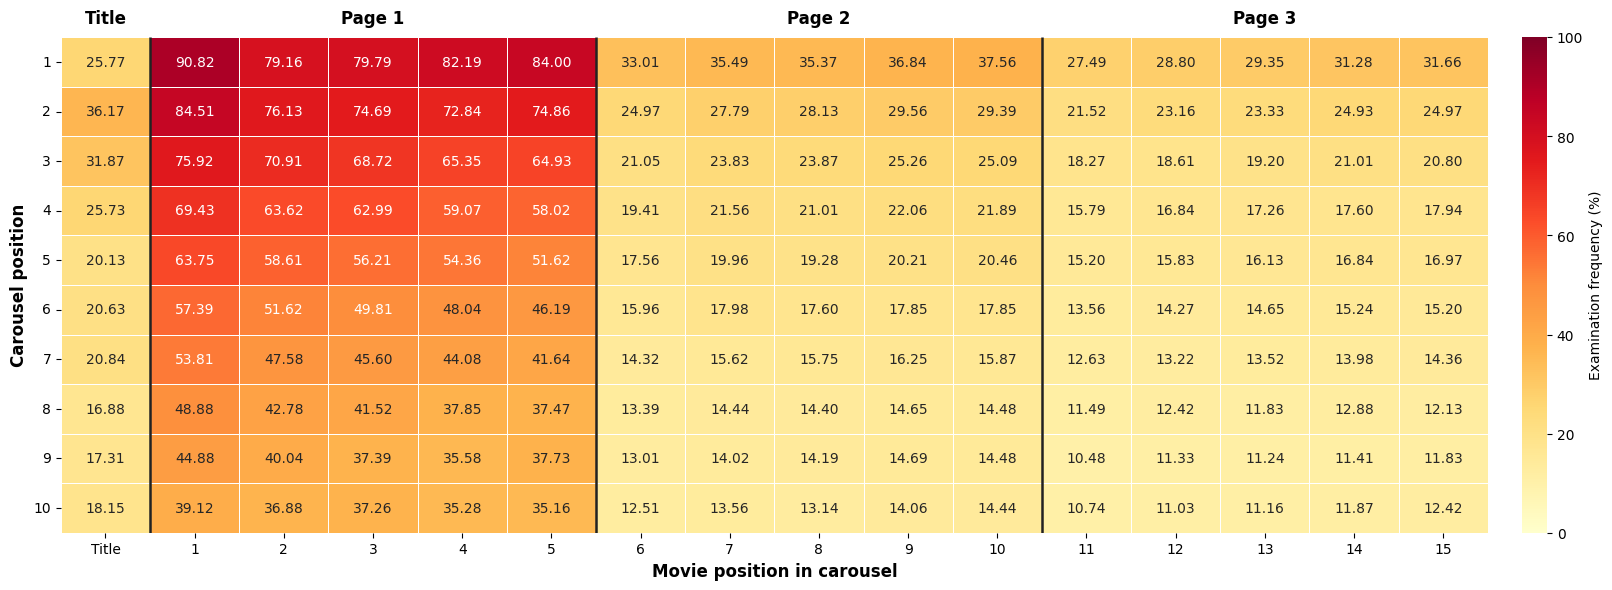

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = binary_exam_result.pivot(
    index="Fixation_AOI_Carousel_position",
    columns="Fixation_AOI_Movie_position_in_carousel",
    values="exam_freq"
)

fig, ax = plt.subplots(figsize=(18, 6))

hm = sns.heatmap(
    pivot_df,
    cmap="YlOrRd",
    annot=True,
    fmt=".2f",
    vmin=0,
    vmax=100,
    linewidths=0.4,
    linecolor="white",
    cbar_kws={
        "label": "Examination frequency (%)",
        "pad": 0.02
    },
    ax=ax
)



ax.set_xlabel("Movie position in carousel", fontsize=12,
        fontweight="bold")
ax.set_ylabel("Carousel position", fontsize=12,
        fontweight="bold")

n_cols = len(pivot_df.columns)
xticks = np.arange(n_cols) + 0.5
xlabels = ["Title"] + list(range(1, 16))
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=0)

n_rows = pivot_df.shape[0]
yticks = np.arange(n_rows) + 0.5
ylabels = list(range(1, n_rows + 1))
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels, rotation=0)

for x in [1, 6, 11]:
    ax.vlines(
        x,
        *ax.get_ylim(),
        colors="#222222",
        linewidth=1.8
    )

group_centers = {"Title": 0,"Page 1": 3, "Page 2": 8, "Page 3": 13}
for label, col_idx in group_centers.items():
    ax.text(
        (col_idx + 0.5) / n_cols,
        1.02,
        label,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )


plt.tight_layout()
plt.show()


# Figure 4 in the paper

In [4]:
aoi_col = "Fixation_AOI_type"
user_col = "UserID"
task_col = "TaskID"
order_col = "Timestamp"

x_col = "Fixation_AOI_Carousel_position"
y_col = "Fixation_AOI_Movie_position_in_carousel"

df = interactions_before_click_free_browsing.copy()

dup_col = "duplicate"
cond = (df[x_col] == df[x_col].shift(1)) & (df[y_col] == df[y_col].shift(1)) \
        & (df[user_col] == df[user_col].shift(1)) \
        & (df[task_col] == df[task_col].shift(1))
df[dup_col] = cond
df = df[~df[dup_col]].copy()

scan_paths = pd.DataFrame(columns=['UserID', 'TaskID', 'Path'])
for (user, task), subset in df.groupby(
    ["UserID", "TaskID"]
):
    pairs = subset[["Fixation_AOI_Carousel_position", "Fixation_AOI_Movie_position_in_carousel"]].to_numpy()
    click = interactions_before_click.loc[subset['first_click_index'].unique().astype(int)]
    new_row = {'UserID': user, 'TaskID': task, 'Path': pairs, 'Click': tuple(click[['Click_AOI_Carousel_position', 'Click_AOI_Movie_position_in_carousel']].to_numpy()[0])}
    scan_paths = pd.concat([scan_paths, pd.DataFrame([new_row])], ignore_index=True)

In [5]:
import pandas as pd
from collections import defaultdict
from collections import Counter
from collections import defaultdict

def normalize_point(p):
    return tuple(float(x) for x in p)

def find_cycles_in_path(path, allow_adjacent=False):
    pts = [normalize_point(p) for p in path]
    pos = defaultdict(list)
    for idx, pt in enumerate(pts):
        pos[pt].append(idx)

    min_gap = 1 if allow_adjacent else 2  # j - i >= min_gap
    cycles = []

    for node, idxs in pos.items():
        if len(idxs) < 2:
            continue
        for a, b in zip(idxs, idxs[1:]):
            if b - a >= min_gap:
                cycles.append({
                    'start': a,
                    'end': b,
                    'node': node,
                    'sequence': pts[a:b+1],
                })

    return cycles

In [6]:
scan_paths['cycles'] = scan_paths['Path'].apply(lambda p: find_cycles_in_path(p, allow_adjacent=True))
node_cycle_counts = defaultdict(Counter)

for row_cycles in scan_paths['cycles']:
    for cycle in row_cycles:
        node = cycle['node']
        seq = tuple(cycle['sequence'])
        node_cycle_counts[node][seq] += 1

rows = []
for node, c in node_cycle_counts.items():
    for seq, count in c.items():
        rows.append({'node': node, 'sequence': list(seq), 'count': count})

node_cycle_df = pd.DataFrame(rows).sort_values(['node', 'count'], ascending=[True, False])
node_cycle_df["total"] = node_cycle_df.groupby("node")["count"].transform("sum")
node_cycle_df['proportion'] = node_cycle_df['count'] / node_cycle_df['total']

click_point = scan_paths.loc[0]['Click']
scan_path = scan_paths.loc[0]['Path']

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

GRID_ROWS, GRID_COLS = 10, 15
per_visit = False
def to_int_tuple(t):
    return tuple(int(v) for v in t)

def build_mat_for_center(center, node_cycle_df, GRID_ROWS, GRID_COLS, per_visit):
    sub = scan_paths[scan_paths['Click'].apply(lambda t: to_int_tuple(t) == center)]
    mat = pd.DataFrame(0.0, index=range(1, GRID_ROWS + 1), columns=range(0, GRID_COLS + 1))
    if sub.empty:
        return mat

    hits = Counter()
    for _, row in sub.iterrows():
        seq_points = [to_int_tuple(p) for p in row['Path']]
        if per_visit:
            for rc in seq_points:
                hits[rc] += 1
        else:
            for rc in set(seq_points):
                hits[rc] += 1

    total = len(sub)

    for (r, c), v in hits.items():
        mat.loc[r, c] = v / total * 100.0

    return mat

raw_mats = {}
all_vals = []

for r_center in range(1, GRID_ROWS + 1):
    for c_center in range(1, GRID_COLS + 1):
        center = (r_center, c_center)
        mat = build_mat_for_center(center, node_cycle_df, GRID_ROWS, GRID_COLS, per_visit)
        raw_mats[center] = mat
        all_vals.extend(mat.values.flatten())

In [8]:
processed_data_list = []

for index, row in scan_paths.iterrows():
    scan_id = index
    click_str = row['Click']
    path_str = row['Path']
    click_row = click_str[0]
    click_col = click_str[1]
    all_examined = []
    for i in path_str:
        all_examined.append(tuple(i))

    for i in range(1,11):
        for j in range(0,16):

            target_row = i
            target_col = j
            delta_row = target_row - click_row
            delta_col = target_col - click_col
            euclidean_dist = np.sqrt(delta_row**2 + delta_col**2)
            manhattan_dist = abs(delta_row) + abs(delta_col)
            is_same_row = 1 if target_row == click_row else 0
            is_same_col = 1 if target_col == click_col else 0

            if tuple((target_row, target_col)) in all_examined:
                is_scanned = 1
            else:
                is_scanned = 0

            processed_data_list.append({
                "scan_id": scan_id,
                "click_row": click_row,
                "click_col": click_col,
                "target_row": target_row,
                "target_col": target_col,
                "delta_row": delta_row,
                "delta_col": delta_col,
                "euclidean_dist": euclidean_dist,
                "manhattan_dist": manhattan_dist,
                "is_same_row": is_same_row,
                "is_same_col": is_same_col,
                "is_scanned": is_scanned
            })

df_model = pd.DataFrame(processed_data_list)

In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from lightgbm import LGBMClassifier
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation



feature_columns = [
    "click_row", "click_col", "target_row", "target_col",
    "delta_row", "delta_col", "euclidean_dist", "manhattan_dist",
    "is_same_row", "is_same_col"
]

all_scan_ids = df_model['scan_id'].unique()
train_ids, test_ids = train_test_split(all_scan_ids, test_size=0.15, random_state=42)

train_df = df_model[df_model['scan_id'].isin(train_ids)]
test_df  = df_model[df_model['scan_id'].isin(test_ids)]

X_train = train_df[feature_columns]
y_train = train_df['is_scanned']
X_test  = test_df[feature_columns]
y_test  = test_df['is_scanned']


param_dist_lgbm = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10, 15, 20, -1],
    'num_leaves': [31, 63, 127],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5],
    'min_child_samples': [10, 20, 50],
}

lgbm = LGBMClassifier(
    objective='binary',
    n_jobs=-1,
    random_state=42,
)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=25,
    cv=3,
    scoring='neg_log_loss',
    random_state=42,
    n_jobs=-1,
    verbose=1
)


random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=50)
    ]
)

print("Best Log Loss:", -random_search.best_score_)
print("Best params:", random_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 98766, number of negative: 224114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 322880, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.305891 -> initscore=-0.819401
[LightGBM] [Info] Start training from score -0.819401
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.477926
[100]	valid_0's binary_logloss: 0.479122
[150]	valid_0's binary_logloss: 0.481033
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.477926
Best Log Loss: 0.4760604223458282
Best params: {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 50

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

final_model = random_search.best_estimator_

GRID_ROWS, GRID_COLS = 10, 15
per_visit = False
def to_int_tuple(t):
    return tuple(int(v) for v in t)


def build_mat_for_center(r_center, c_center):
    prediction_features_list = []
    for target_r in range(1,11):
        for target_c in range(0,16):
            feat_delta_row = target_r - r_center
            feat_delta_col = target_c - c_center
            feat_euclidean_dist = np.sqrt(feat_delta_row**2 + feat_delta_col**2)
            feat_manhattan_dist = abs(feat_delta_row) + abs(feat_delta_col)

            prediction_features_list.append({
                "click_row": r_center,
                "click_col": c_center,
                "target_row": target_r,
                "target_col": target_c,
                "delta_row": feat_delta_row,
                "delta_col": feat_delta_col,
                "euclidean_dist": feat_euclidean_dist,
                "manhattan_dist": feat_manhattan_dist,
                "is_same_row": 1 if target_r == r_center else 0,
                "is_same_col": 1 if target_c == c_center else 0
            })

    df_predict = pd.DataFrame(prediction_features_list)

    probabilities_flat = final_model.predict_proba(df_predict[feature_columns])[:, 1]
    probability_matrix = probabilities_flat.reshape((10, 16)) * 100

    return pd.DataFrame(probability_matrix, index=range(1, 11))

smoothed_mats = {}
all_vals = []

for r_center in range(1, GRID_ROWS + 1):
    for c_center in range(1, GRID_COLS + 1):
        mat = build_mat_for_center(r_center, c_center)
        center = (r_center, c_center)
        smoothed_mats[center] = mat
        all_vals.extend(mat.values.flatten())

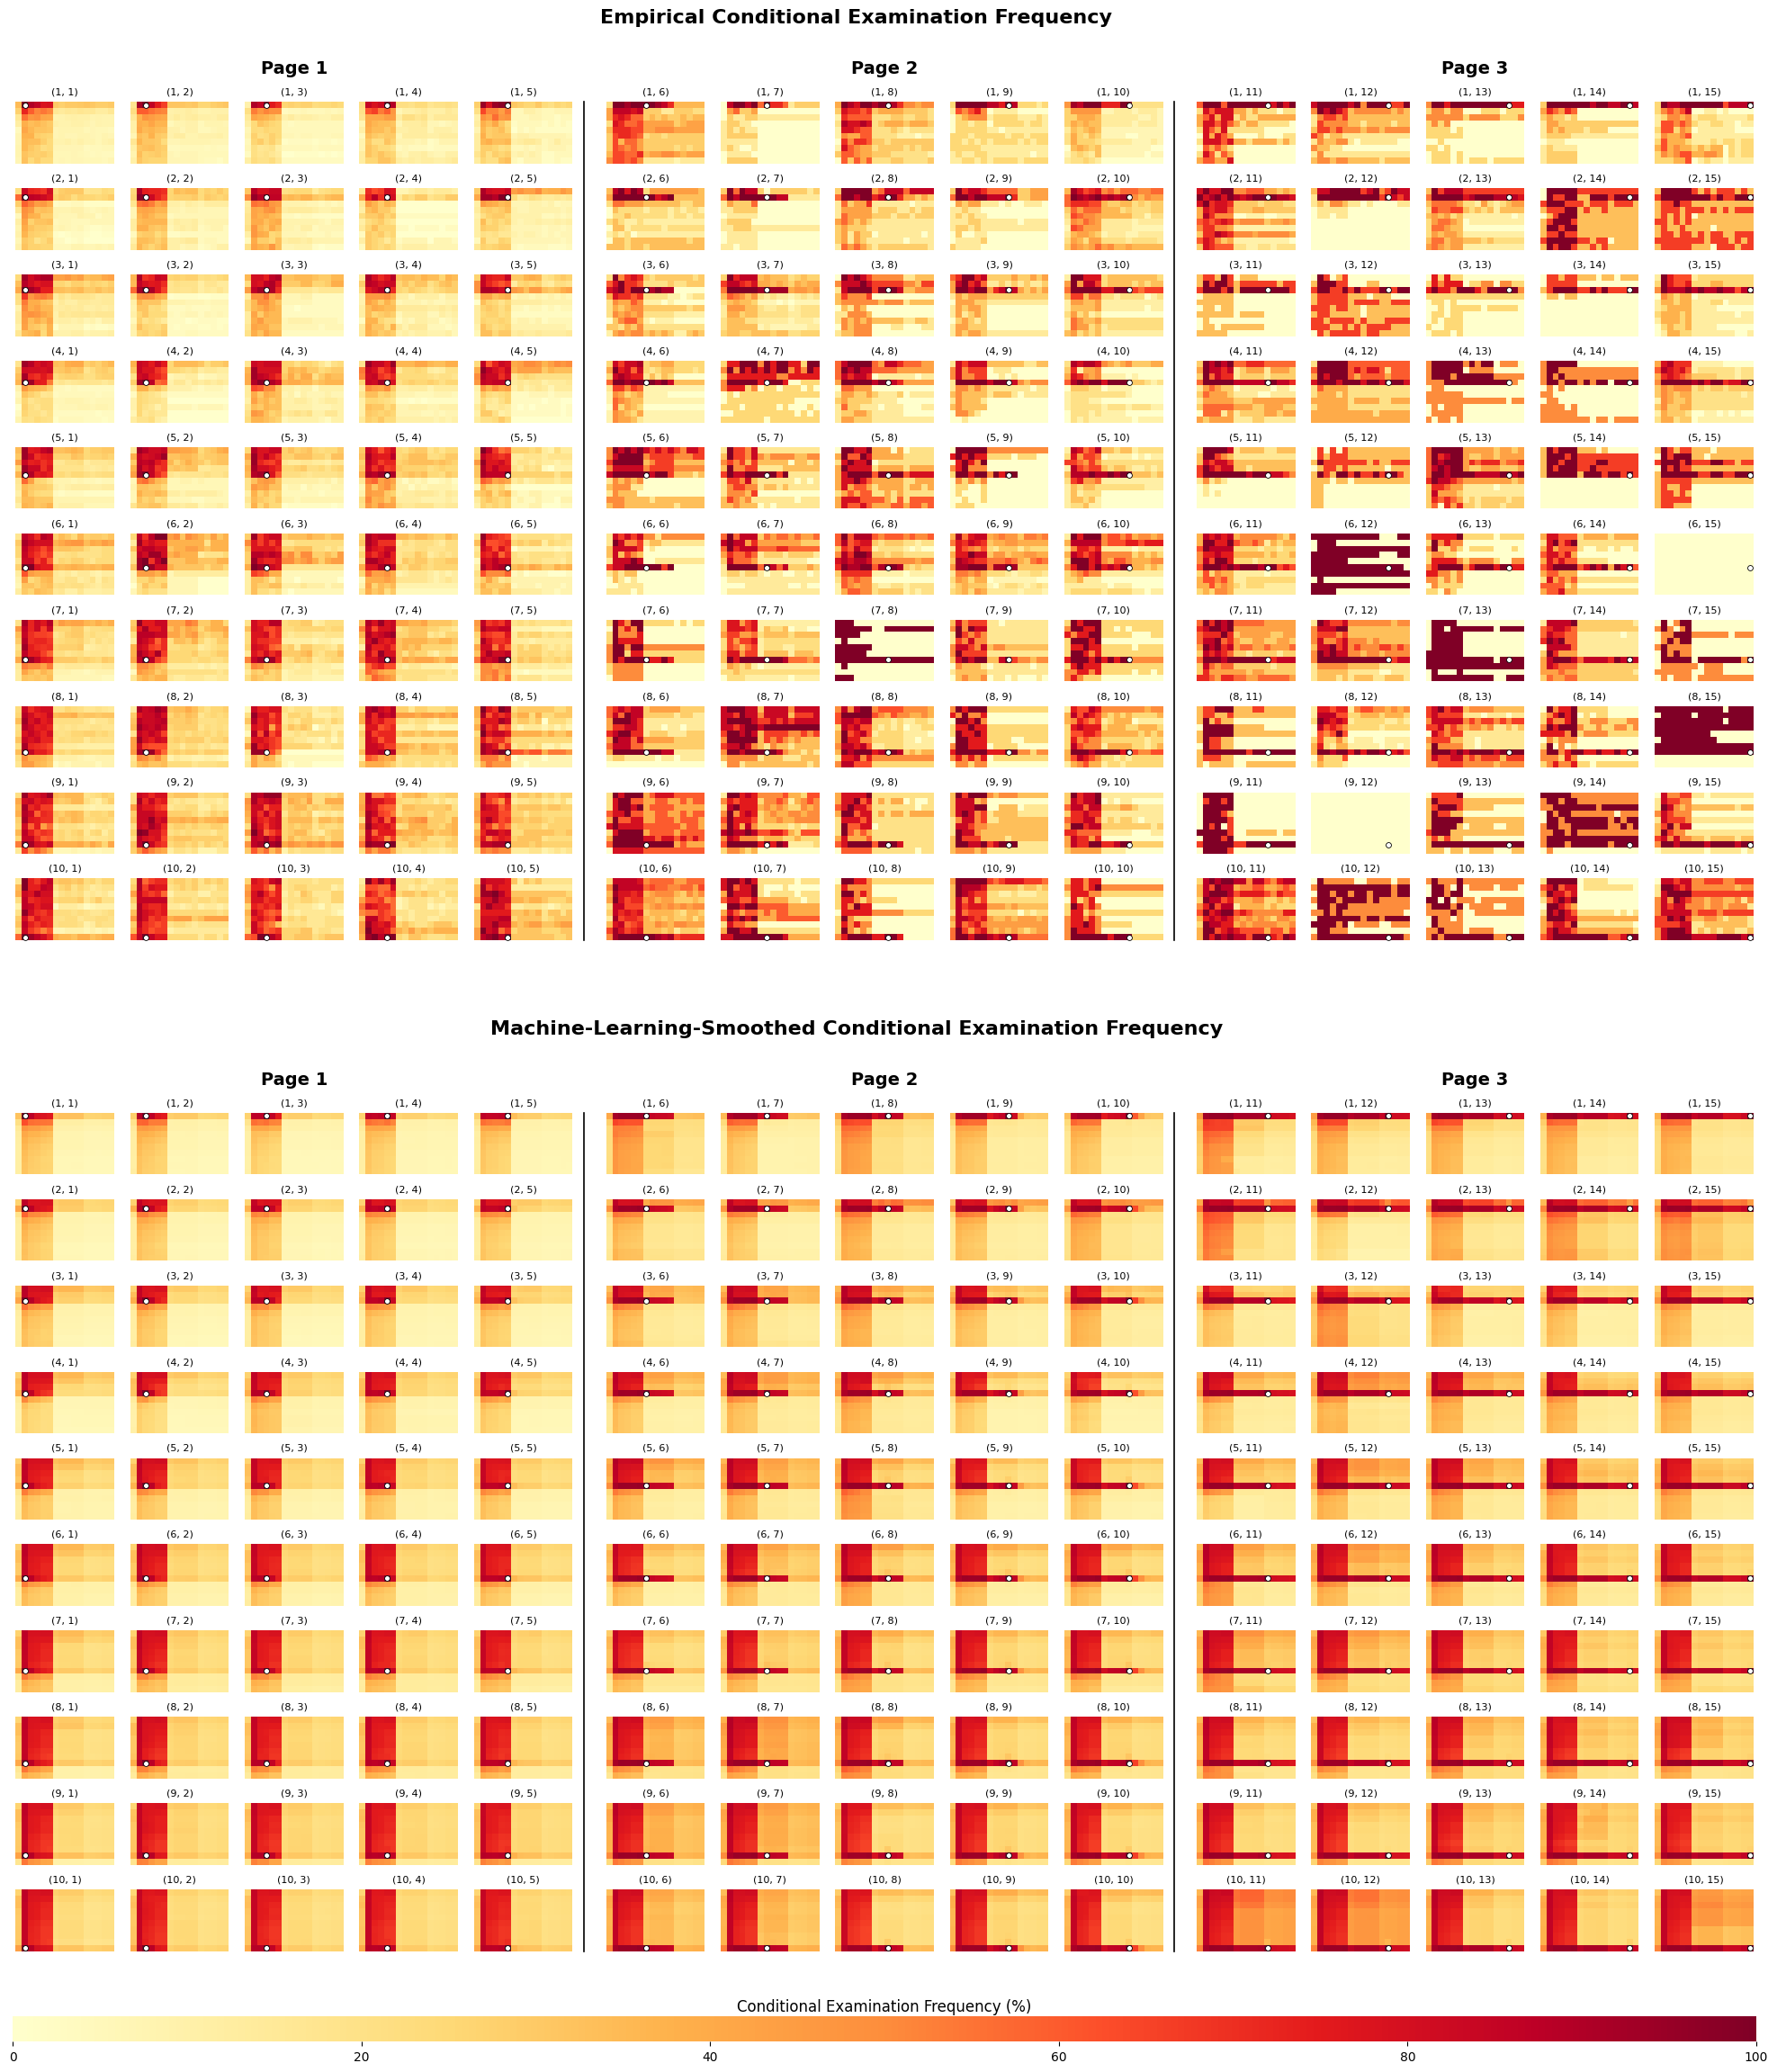

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

cmap = "YlOrRd"

def draw_panel(fig, panel_spec, mats, vmin, vmax, cmap, panel_title):
    outer = gridspec.GridSpecFromSubplotSpec(
        1, 3, subplot_spec=panel_spec,
        width_ratios=[5, 5, 5],
        wspace=0.05
    )

    group_edge_axes = []
    group_anchor_axes = {}
    all_axes = []

    for group_idx in range(3):
        inner = gridspec.GridSpecFromSubplotSpec(
            GRID_ROWS, 5,
            subplot_spec=outer[0, group_idx],
            wspace=0.1, hspace=0.4
        )

        for r_center in range(1, GRID_ROWS + 1):
            for c_local in range(1, 6):
                c_global = group_idx * 5 + c_local
                if c_global > GRID_COLS:
                    continue

                ax = fig.add_subplot(inner[r_center - 1, c_local - 1])
                all_axes.append(ax)

                mat = mats[(r_center, c_global)]

                sns.heatmap(
                    mat,
                    cmap=cmap,
                    vmin=vmin, vmax=vmax,
                    cbar=False,
                    square=True,
                    ax=ax,
                    xticklabels=False,
                    yticklabels=False,
                )

                ax.scatter(
                    c_global + 0.5,
                    r_center - 0.5,
                    facecolor="white",
                    edgecolor="black",
                    linewidth=0.6,
                    s=18,
                    zorder=3
                )
                ax.set_title(f"({r_center}, {c_global})", fontsize=8)

                if r_center == 1 and c_local == 1:
                    group_anchor_axes.setdefault(group_idx, {})["left"] = ax
                if r_center == 1 and c_local == 5:
                    group_anchor_axes.setdefault(group_idx, {})["right"] = ax
                    group_edge_axes.append(ax)


    y0 = min(ax.get_position().y0 for ax in all_axes)
    y1 = max(ax.get_position().y1 for ax in all_axes)

    for ax in group_edge_axes[:-1]:
        bbox = ax.get_position()
        x = bbox.x1 + 0.005
        fig.add_artist(
            plt.Line2D(
                [x, x],
                [y0, y1],
                transform=fig.transFigure,
                color="black",
                linewidth=1.2,
            )
        )

    group_titles = ["Page 1", "Page 2", "Page 3"]
    y_offset = 0.01

    for group_idx, title in enumerate(group_titles):
        left_ax = group_anchor_axes[group_idx]["left"]
        right_ax = group_anchor_axes[group_idx]["right"]
        left_bbox = left_ax.get_position()
        right_bbox = right_ax.get_position()

        x_center = (left_bbox.x0 + right_bbox.x1) / 2
        y = left_bbox.y1 + y_offset

        fig.text(
            x_center, y,
            title,
            ha="center",
            va="bottom",
            fontsize=14,
            fontweight="bold"
        )

    fig.text(
        0.5, y1 + 0.03,
        panel_title,
        ha="center",
        va="bottom",
        fontsize=16,
        fontweight="bold"
    )

    return all_axes


fig = plt.figure(figsize=(25, 28))

gs = gridspec.GridSpec(
    4, 1,
    height_ratios=[1, 0.05, 1, 0.03],
    hspace=0.15
)


axes_top = draw_panel(
    fig, gs[0, 0],
    mats=raw_mats,
    vmin=0, vmax=100,
    cmap=cmap,
    panel_title="Empirical Conditional Examination Frequency"
)


ax_spacer = fig.add_subplot(gs[1, 0])
ax_spacer.axis("off")


axes_bottom = draw_panel(
    fig, gs[2, 0],
    mats=smoothed_mats,
    vmin=0, vmax=100,
    cmap=cmap,
    panel_title="Machine-Learning-Smoothed Conditional Examination Frequency"
)


norm = Normalize(vmin=0, vmax=100)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar_ax = fig.add_subplot(gs[3, 0])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Conditional Examination Frequency (%)", fontsize=12)
cbar.ax.tick_params(labelsize=10)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")

cbar_ax.set_frame_on(False)
plt.show()


# Figure 5 in the paper

In [12]:
clicks = interactions_before_click.loc[df['first_click_index'].unique().astype(int)]
clicks = pd.DataFrame(clicks[['Click_AOI_Carousel_position', 'Click_AOI_Movie_position_in_carousel']].to_numpy())
clicks.columns = ['Click_AOI_Carousel_position', 'Click_AOI_Movie_position_in_carousel']
click_result = clicks.groupby(['Click_AOI_Carousel_position', 'Click_AOI_Movie_position_in_carousel']).size().reset_index(name='count')
click_result['click_prob'] = click_result['count'] / len(clicks) * 100
click_result.rename(columns={'Click_AOI_Carousel_position': 'AOI_Carousel_position', 'Click_AOI_Movie_position_in_carousel': 'AOI_Movie_position_in_carousel'}, inplace=True)
binary_exam_result.rename(columns={'Fixation_AOI_Carousel_position': 'AOI_Carousel_position', 'Fixation_AOI_Movie_position_in_carousel': 'AOI_Movie_position_in_carousel'}, inplace=True)

merged = click_result.merge(binary_exam_result, on=['AOI_Carousel_position', 'AOI_Movie_position_in_carousel'], how='inner')
merged['ctr'] = merged['count'] / merged['n_users_tasks'] * 100
# two positions without any click
new_row = pd.DataFrame([{"AOI_Carousel_position": 6.0, "AOI_Movie_position_in_carousel": 15.0, 'count': 0, 'n_users_tasks': 361},
 {"AOI_Carousel_position": 9.0, "AOI_Movie_position_in_carousel": 12.0, 'count': 0, 'n_users_tasks': 269}])
merged = pd.concat([merged, new_row], ignore_index=True)

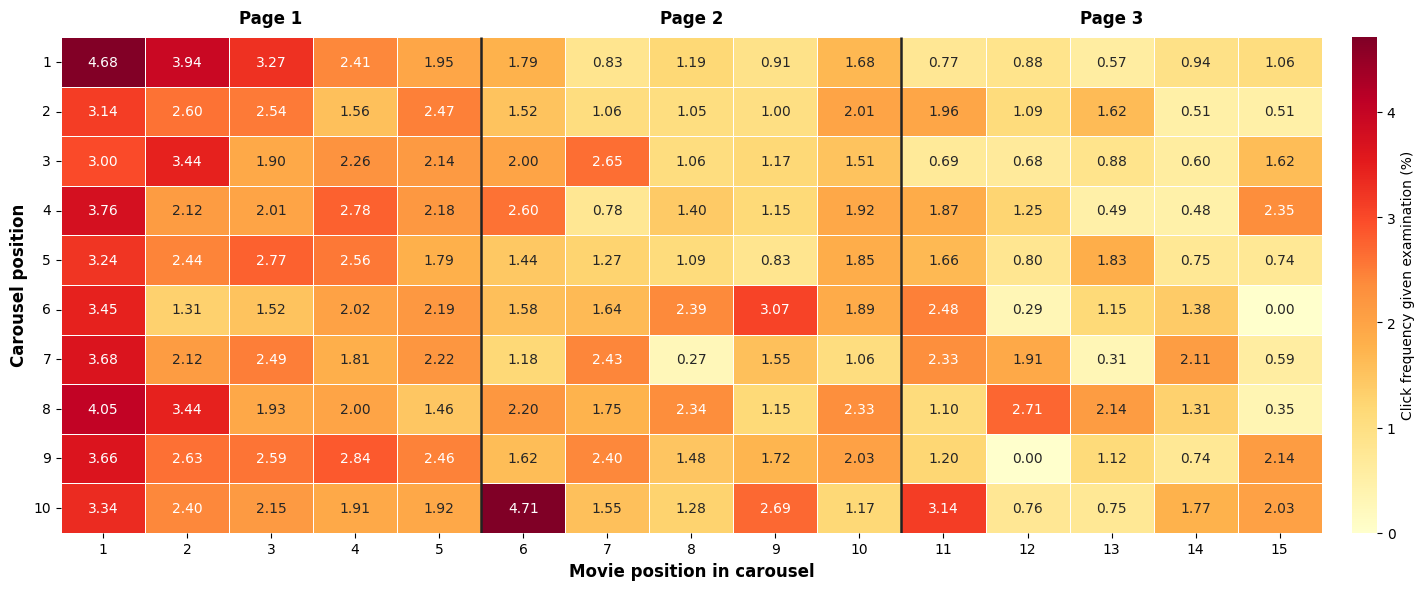

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = merged.pivot(
    index="AOI_Carousel_position",
    columns="AOI_Movie_position_in_carousel",
    values="ctr"
)

pivot_df = pivot_df.fillna(0)

pivot_df = pivot_df.sort_index(axis=1).sort_index(axis=0)

fig, ax = plt.subplots(figsize=(16, 6))

hm = sns.heatmap(
    pivot_df,
    cmap="YlOrRd",
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={
        "label": "Click frequency given examination (%)",
        "pad": 0.02
    },
    ax=ax
)

ax.set_xlabel("Movie position in carousel", fontsize=12,
        fontweight="bold")
ax.set_ylabel("Carousel position", fontsize=12,
        fontweight="bold")


n_cols = len(pivot_df.columns)
n_rows = len(pivot_df.index)

ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_yticks(np.arange(n_rows) + 0.5)


cols = list(pivot_df.columns)
has_title_col = (0 in cols)

if has_title_col:
    xlabels = ["title"] + [str(c) for c in cols if c != 0]
else:
    xlabels = [int(c) for c in cols]

ax.set_xticklabels(xlabels, rotation=0)
ax.set_yticklabels([int(i) for i in pivot_df.index], rotation=0)


if has_title_col:
    separators = [1, 6, 11]
else:
    separators = [5, 10]

for x in separators:
    ax.vlines(x, *ax.get_ylim(), colors="#222222", linewidth=1.8)


if has_title_col:
    group_centers = {"title": 0, "Page 1": 3, "Page 2": 8, "Page 3": 13}
else:
    group_centers = {"Page 1": 2, "Page 2": 7, "Page 3": 12}

for label, col_idx in group_centers.items():
    ax.text(
        (col_idx + 0.5) / n_cols,
        1.02,
        label,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


# Table 1

In [14]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest


df = merged[['AOI_Carousel_position','AOI_Movie_position_in_carousel','count','n_users_tasks','ctr']].copy()


df['relative_rank'] = df.groupby('AOI_Carousel_position')['AOI_Movie_position_in_carousel'].rank(method='first')


row_a_id = 1.0
row_b_id = 6.0

row_a = df[df['AOI_Carousel_position'] == row_a_id].set_index('relative_rank')
row_b = df[df['AOI_Carousel_position'] == row_b_id].set_index('relative_rank')


print(f"--- Compare Row {int(row_a_id)} vs Row {int(row_b_id)} (Z Test) ---")
print(f"{'Pos':<5} | {'CTR_Row'+str(int(row_a_id)):<10} | {'CTR_Row'+str(int(row_b_id)):<10} | {'Diff':<8} | {'P-Value':<8} | {'Significant?'}")

for pos in range(1,6):
    n_succ_a = row_a.loc[pos, 'count']
    n_obs_a  = row_a.loc[pos, 'n_users_tasks']

    n_succ_b = row_b.loc[pos, 'count']
    n_obs_b  = row_b.loc[pos, 'n_users_tasks']


    stat, p_value = proportions_ztest([n_succ_a, n_succ_b], [n_obs_a, n_obs_b], alternative='two-sided')

    ctr_a = n_succ_a / n_obs_a
    ctr_b = n_succ_b / n_obs_b
    diff = ctr_a - ctr_b
    is_sig = "YES" if p_value < 0.05 else "No"

    print(f"{int(pos):<5} | {ctr_a:.4f}     | {ctr_b:.4f}     | {diff:+.4f}   | {p_value:.4f}   | {is_sig}")

--- Compare Row 1 vs Row 6 (Z Test) ---
Pos   | CTR_Row1   | CTR_Row6   | Diff     | P-Value  | Significant?
1     | 0.0468     | 0.0345     | +0.0123   | 0.0755   | No
2     | 0.0394     | 0.0131     | +0.0263   | 0.0000   | YES
3     | 0.0327     | 0.0152     | +0.0175   | 0.0030   | YES
4     | 0.0241     | 0.0202     | +0.0039   | 0.4794   | No
5     | 0.0195     | 0.0219     | -0.0023   | 0.6610   | No


# Figure 6 in the paper

In [15]:
boundaries = np.arange(0, 101, 1)

def split_row(row):
    start, end, duration = row["start_pct"], row["end_pct"], row["Fixation_Duration"]
    points = [b for b in boundaries if start < b < end]
    segments = [start] + points + [end]

    new_rows = []
    for i in range(len(segments) - 1):
        seg_start, seg_end = segments[i], segments[i+1]
        seg_len = seg_end - seg_start
        total_len = end - start
        seg_duration = duration * (seg_len / total_len)

        new_row = row.copy()
        new_row["start_pct"] = seg_start
        new_row["end_pct"] = seg_end
        new_row["Fixation_Duration"] = seg_duration
        new_rows.append(new_row)
    return new_rows

def extended_dataset(interactions):
    interactions["total_time"] = interactions.groupby(['UserID', 'TaskID'])['Fixation_Duration'].transform('sum')
    interactions['Cumulative_Time'] = interactions.groupby(['UserID', 'TaskID'])['Fixation_Duration'].cumsum()
    interactions['Time_Percent'] = interactions['Cumulative_Time'] / interactions["total_time"] * 100

    df = interactions
    df['start_pct'] = df.groupby(['UserID','TaskID'])['Time_Percent'].shift(fill_value=0)
    df['start_time'] = df.groupby(['UserID','TaskID'])['Cumulative_Time'].shift(fill_value=0)
    df['end_pct'] = df['Time_Percent']
    df['end_time'] = df['Cumulative_Time']
    df = pd.DataFrame([r for _, row in df.iterrows() for r in split_row(row)])

    return df

interactions_before_click_free_browsing_extended = extended_dataset(interactions_before_click_free_browsing.copy())

In [16]:
aoi_col = "Fixation_AOI_type"
user_col = "UserID"
task_col = "TaskID"
order_col = "Timestamp"

x_col = "Fixation_AOI_Carousel_position"
y_col = "Fixation_AOI_Movie_position_in_carousel"

df = interactions_before_click_free_browsing_extended.copy()

dup_col = "duplicate"
cond = (df[x_col] == df[x_col].shift(1)) & (df[y_col] == df[y_col].shift(1)) \
        & (df[user_col] == df[user_col].shift(1)) \
        & (df[task_col] == df[task_col].shift(1))
df[dup_col] = cond
df = df[~df[dup_col]].copy()


find = df.groupby(['UserID', 'TaskID', x_col, y_col]).first().reset_index()
df = find[['UserID', 'TaskID', x_col, y_col, 'start_pct']].copy()
df = df.rename(columns={
    'Fixation_AOI_Carousel_position': 'row',
    'Fixation_AOI_Movie_position_in_carousel': 'column',
    'start_pct': 'arrival_time'
})

# Rank arrival time within each (UserID, TaskID) session
df['arrival_rank'] = df.groupby(['UserID','TaskID'])['arrival_time'].rank(method='dense', ascending=True)

df_sorted = df.sort_values(
    by=['UserID', 'TaskID', 'arrival_rank'],
    ascending=[True, True, True]
)

In [17]:
results = []

for r in range(1, 11):
    df_row_exam = df_sorted.query(f"row == {r}").copy()
    row_examined = len(df_sorted.query(f"row == {r}").groupby(["UserID", "TaskID"]))

    df_title = df_row_exam.query(f"row == {r} and column == 0").copy()

    title_min = (
        df_title
        .groupby(["UserID", "TaskID"], as_index=False)["arrival_rank"]
        .min()
        .rename(columns={"arrival_rank": "title_arrival_rank"})
    )


    df_item = df_row_exam.query(f"row == {r} and column != 0").copy()
    item_min = (
        df_item
        .groupby(["UserID", "TaskID"], as_index=False)["arrival_rank"]
        .min()
        .rename(columns={"arrival_rank": "item_min_arrival_rank"})
    )

    df_only_title_is_examined = title_min.merge(item_min, on=["UserID", "TaskID"], how="left")
    only_title_is_examined = df_only_title_is_examined["item_min_arrival_rank"].isna().sum()



    df_cmp = item_min.merge(title_min, on=["UserID", "TaskID"], how="left")
    only_item_is_examined = df_cmp["title_arrival_rank"].isna().sum()
    item_exam_with_title = df_cmp["title_arrival_rank"].notna().sum()

    title_before_item_when_both = df_cmp["title_arrival_rank"] < df_cmp["item_min_arrival_rank"]



    df_title_before_item = title_min.merge(item_min, on=["UserID", "TaskID"], how="left").fillna(np.inf)
    before_mask = df_title_before_item["title_arrival_rank"] < df_title_before_item["item_min_arrival_rank"]
    title_before_item = before_mask.sum()

    results.append({
        "row": r,
        "at least one position": row_examined,
        "only title": only_title_is_examined,
        "title before earliest item when both": title_before_item_when_both.sum(),
        "title before any item": title_before_item,
        "percentage": title_before_item / row_examined * 100,
    })

df_stats = pd.DataFrame(results)
df_stats

,row,at least one position,only title,title before earliest item when both,title before any item,percentage
0,1,2327,2,46,48,2.062742
1,2,2273,12,138,150,6.599208
2,3,2072,20,172,192,9.266409
3,4,1883,8,145,153,8.125332
4,5,1704,9,89,98,5.751174
5,6,1567,5,122,127,8.104659
6,7,1456,13,111,124,8.516484
7,8,1336,7,107,114,8.532934
8,9,1211,5,104,109,9.000826
9,10,1100,9,157,166,15.090909


In [18]:
import pandas as pd

results = []

for r in range(1, 11):

    df_title = df_sorted.query(f"row == {r} and column == 0").copy()

    title_min = (
        df_title
        .groupby(["UserID", "TaskID"], as_index=False)["arrival_rank"]
        .min()
        .rename(columns={"arrival_rank": "title_arrival_rank"})
    )


    for c in range(1, 16):
        df_filtered = df_sorted.query(f"row == {r} and column == {c}").copy()
        item_exam = len(df_filtered)


        if item_exam == 0:
            item_exam_before_title = 0
            item_exam_with_title = 0
            percentage_before_title = 0.0
            percentage_with_title = 0.0
        else:
            df_cmp = df_filtered.merge(title_min, on=["UserID", "TaskID"], how="left")

            item_exam_with_title = df_cmp["title_arrival_rank"].notna().sum()

            before_mask = df_cmp["title_arrival_rank"].notna() & (
                df_cmp["arrival_rank"] < df_cmp["title_arrival_rank"]
            )
            item_exam_before_title = before_mask.sum()

            only_item_is_examined = df_cmp["title_arrival_rank"].isna().sum()

            percentage_before_title = item_exam_before_title / item_exam
            percentage_with_title = item_exam_with_title / item_exam

        results.append({
            "row": r,
            "column": c,
            "item_examined": item_exam,
            "only_item_is_examined": only_item_is_examined,
            "item_examined_before_title": item_exam_before_title,
            "percentage": (only_item_is_examined+item_exam_before_title) / item_exam * 100,
        })

df_stats = pd.DataFrame(results)

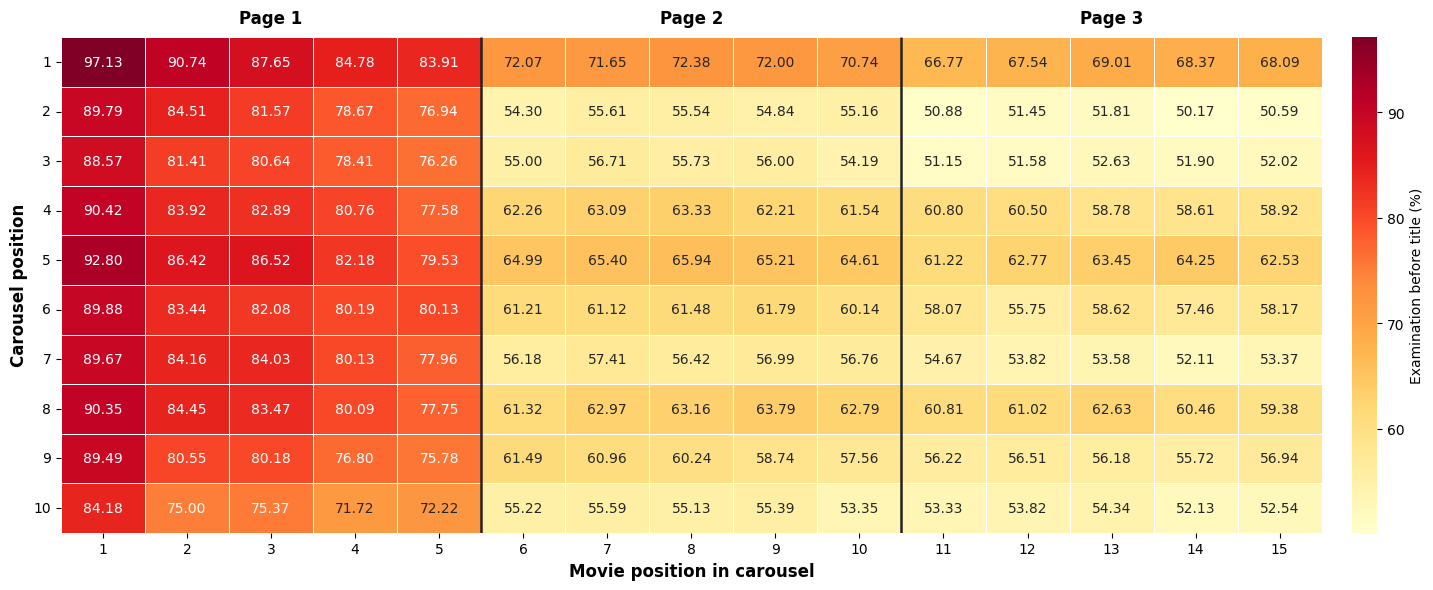

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = df_stats.pivot(index="row", columns="column", values="percentage")

pivot_df = pivot_df.fillna(0)

pivot_df = pivot_df.sort_index(axis=1).sort_index(axis=0)

fig, ax = plt.subplots(figsize=(16, 6))

hm = sns.heatmap(
    pivot_df,
    cmap="YlOrRd",
    annot=True,
    fmt=".2f",
    linewidths=0.4,
    linecolor="white",
    cbar_kws={
        "label": "Examination before title (%)",
        "pad": 0.02
    },
    ax=ax
)

ax.set_xlabel("Movie position in carousel", fontsize=12,
        fontweight="bold")
ax.set_ylabel("Carousel position", fontsize=12,
        fontweight="bold")

n_cols = len(pivot_df.columns)
n_rows = len(pivot_df.index)

ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_yticks(np.arange(n_rows) + 0.5)

cols = list(pivot_df.columns)
has_title_col = (0 in cols)

if has_title_col:
    xlabels = ["title"] + [str(c) for c in cols if c != 0]
else:
    xlabels = [int(c) for c in cols]

ax.set_xticklabels(xlabels, rotation=0)
ax.set_yticklabels([int(i) for i in pivot_df.index], rotation=0)

if has_title_col:
    separators = [1, 6, 11]
else:
    separators = [5, 10]

for x in separators:
    ax.vlines(x, *ax.get_ylim(), colors="#222222", linewidth=1.8)

if has_title_col:
    group_centers = {"title": 0, "Page 1": 3, "Page 2": 8, "Page 3": 13}
else:
    group_centers = {"Page 1": 2, "Page 2": 7, "Page 3": 12}

for label, col_idx in group_centers.items():
    ax.text(
        (col_idx + 0.5) / n_cols,
        1.02,
        label,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()